# 0 Utils

## 0.1 Imports and paths

In [40]:
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter

user_study_data_folder = f'/home/janko/Desktop/social-dining/data/user-study'

pre_study_questionnaire_file = f'{user_study_data_folder}/questionnaires/Pre-StudyQuestionnaire.csv'
experiment_questionnaire_file = f'{user_study_data_folder}/questionnaires/ExperimentQuestionnaire.csv'
study_conditions_file = f'{user_study_data_folder}/conditions.csv'


## 0.2 Plotting

In [33]:
def get_colors_list(n):
    return list(mcolors.TABLEAU_COLORS.keys())[:n]

def boldit(text):
    return rf'\textbf{{{text}}}'

def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    # https://stackoverflow.com/a/52333561
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)


## 0.3 Statistics

In [3]:
def print_array_stats(arr, label):
    print(f"{label}:\n \t Min: {np.min(arr)} \t Max: {np.max(arr)} \t Mean: {np.mean(arr)} \t Std: {np.std(arr)} \t Median: {np.median(arr)}")

def print_item_counts(items, label):
    total_count = sum([v for _, v in items])
    print(f'{label}:')
    for k, v in items:
        print(f'\t{k}: {v} ({100 * v / total_count:.2f}%)')


## 0.4 Load questionnaire and study conditions data

In [4]:
# Note: first two rows contain headers => use [2:]
pre_df = pd.read_csv(pre_study_questionnaire_file)[2:].reset_index(drop=True)
exp_df = pd.read_csv(experiment_questionnaire_file)[2:].reset_index(drop=True)

# Sort by video id ({session_id}_{participant_position})
pre_df  = pre_df.sort_values(by=['I2', 'I3']).reset_index(drop=True)
exp_df = exp_df.sort_values(by=['I1', 'I2']).reset_index(drop=True)

conditions_df = pd.read_csv(study_conditions_file).reset_index(drop=True)


# 1 Pre-study questionnaire

## 1.1 Data validation

In [5]:
assert all(pre_df['Progress'] == '100')
assert all(pre_df['Finished'] == 'True')
for i in range(len(pre_df) // 3):
    for j in range(3):
        # Session ID
        assert pre_df['I2'][i * 3 + j] == f'{i + 1:02d}', f"{i}_{j}: {pre_df['I2'][i * 3 + j]} != {i + 1:02d}"
        # Participant position
        assert pre_df['I3'][i * 3 + j][:1] == f'{j + 1:01d}', f"{i}_{j}: {pre_df['I3'][i * 3 + j]} != {j + 1:01d}"


## 1.2 Meal time
Time when the meal was eaten (i.e. when the experiment was performed).

Meal time (when the meal started):
 	 Min: 11 	 Max: 20 	 Mean: 14.9 	 Std: 3.1128764832546763 	 Median: 14.0


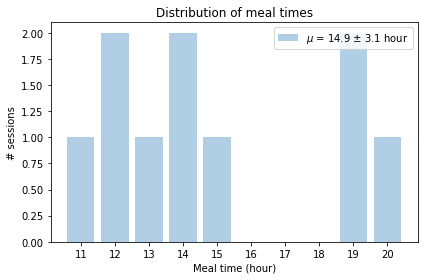

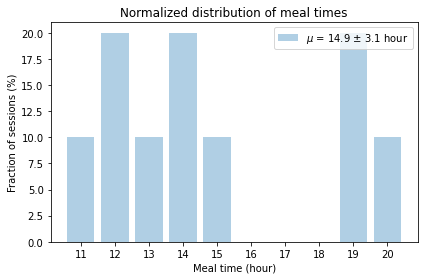

Meal times:
	Breakfast: 0 (0.00%)
	Lunch: 7 (70.00%)
	Dinner: 3 (30.00%)


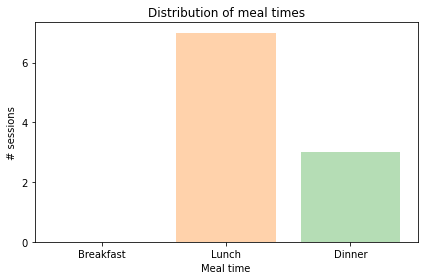

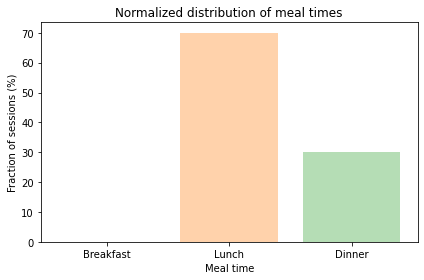

In [6]:
# Shift by two hours because the times (when the pre-study questionnaire was filled in) were automatically collected in the MDT time zone
meal_times = [ t.hour + 2 + (1 if t.minute > 30 else 0) for t in pd.to_datetime(pre_df['EndDate']) ]
for i in range(len(meal_times) // 3):
    # Check the meal times recorded for participants within one session agree
    assert len(set(meal_times[i * 3 : i * 3 + 3])) == 1, f'{i}: {meal_times[i * 3 : i * 3 + 3]}'
meal_times = meal_times[::3]
print_array_stats(meal_times, 'Meal time (when the meal started)')

plt.figure()
time_range = np.arange(min(meal_times), max(meal_times) + 2)
plt.bar(time_range[:-1], np.histogram(meal_times, bins=time_range)[0], alpha=0.35, label=fr'$\mu$ = {np.mean(meal_times):.1f} $\pm$ {np.std(meal_times):.1f} hour')
plt.legend()
plt.xticks(time_range[:-1], time_range[:-1])
plt.xlabel('Meal time (hour)')
plt.ylabel('# sessions')
plt.title("Distribution of meal times")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(time_range[:-1], np.histogram(meal_times, bins=time_range)[0] * 100 / (len(pre_df)//3), alpha=0.35, label=fr'$\mu$ = {np.mean(meal_times):.1f} $\pm$ {np.std(meal_times):.1f} hour')
plt.legend()
plt.xticks(time_range[:-1], time_range[:-1])
plt.xlabel('Meal time (hour)')
plt.ylabel('Fraction of sessions (%)')
plt.title("Normalized distribution of meal times")
plt.tight_layout()
plt.show()

# Categorize into breakfast, lunch, and dinner times
categorized_meal_times = dict(zip(['Breakfast', 'Lunch', 'Dinner'], np.histogram(meal_times, bins=[8, 10.5, 16, 21])[0]))
print_item_counts(categorized_meal_times.items(), 'Meal times')
plt.figure()
plt.bar(categorized_meal_times.keys(), categorized_meal_times.values(), alpha=0.35, color=get_colors_list(len(categorized_meal_times)))
plt.xlabel('Meal time')
plt.yticks(range(max(categorized_meal_times.values()) + 1)[::2])
plt.ylabel('# sessions')
plt.title("Distribution of meal times")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(categorized_meal_times.keys(), np.array(list(categorized_meal_times.values())) * 100 / (len(pre_df)//3), alpha=0.35, color=get_colors_list(len(categorized_meal_times)))
plt.xlabel('Meal time')
plt.ylabel('Fraction of sessions (%)')
plt.title("Normalized distribution of meal times")
plt.tight_layout()
plt.show()


## 1.3 Demographics

### 1.3.1 Age

Age:
 	 Min: 19 	 Max: 70 	 Mean: 26.833333333333332 	 Std: 9.187249618659306 	 Median: 24.0


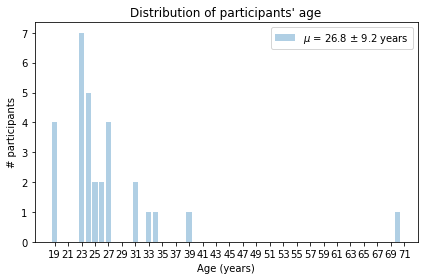

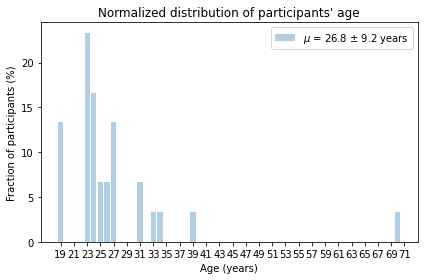

In [7]:
age = pd.to_numeric(pre_df['D1'])
print_array_stats(age, 'Age')

plt.figure()
age_range = np.arange(min(age), max(age) + 2)
plt.bar(age_range[:-1], np.histogram(age, bins=age_range)[0], alpha=0.35, label=fr'$\mu$ = {np.mean(age):.1f} $\pm$ {np.std(age):.1f} years')
plt.legend()
plt.xticks(age_range[::2])
plt.xlabel('Age (years)')
plt.ylabel('# participants')
plt.title("Distribution of participants' age")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(age_range[:-1], np.histogram(age, bins=age_range)[0] * 100 / len(pre_df), alpha=0.35, label=fr'$\mu$ = {np.mean(age):.1f} $\pm$ {np.std(age):.1f} years')
plt.legend()
plt.xticks(age_range[::2])
plt.xlabel('Age (years)')
plt.ylabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' age")
plt.tight_layout()
plt.show()


### 1.3.2 Gender

Gender:
	Male: 14 (46.67%)
	Female: 16 (53.33%)


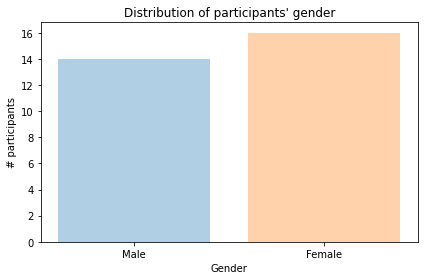

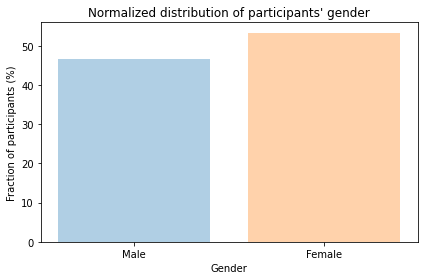

In [8]:
genders = Counter(pre_df['D2'])
print_item_counts(genders.items(), 'Gender')

plt.figure()
plt.bar(genders.keys(), genders.values(), alpha=0.35, color=get_colors_list(len(genders)))
plt.xlabel('Gender')
plt.ylabel('# participants')
plt.title("Distribution of participants' gender")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(genders.keys(), np.array(list(genders.values())) * 100 / len(pre_df), alpha=0.35, color=get_colors_list(len(genders)))
plt.xlabel('Gender')
plt.ylabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' gender")
plt.tight_layout()
plt.show()


### 1.3.3 Race

Race:
	White: 13 (43.33%)
	Asian: 15 (50.00%)
	Other or two/more races: 1 (3.33%)
	Black or African American: 1 (3.33%)
		 White and Asian 


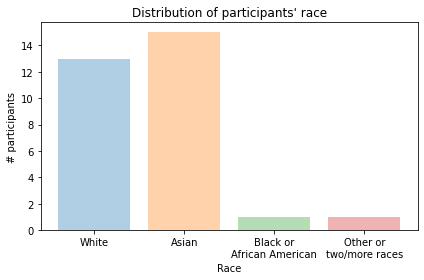

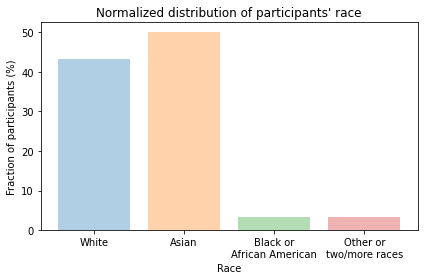

In [9]:
races_counter = Counter(pre_df['D3'])
print_item_counts(races_counter.items(), 'Race')

# Show details for 'Other or two/more races'
for i, race in enumerate(pre_df[f'D3']):
    if race == 'Other or two/more races':
        print(f"\t\t {pre_df[f'D3_6_TEXT'][i]}")

races = [
    'White',
    'Asian',
    'Black or African American',
    'Other or two/more races'
]
races_labels = [
    'White',
    'Asian',
    'Black or\nAfrican American',
    'Other or\ntwo/more races'
]
races_range = np.arange(len(races))
races_values = [races_counter[race] if race in races_counter else 0 for race in races]
plt.figure()
plt.bar(races_range, races_values, alpha=0.35, color=get_colors_list(len(races)))
plt.xticks(races_range, races_labels)
plt.xlabel('Race')
plt.ylabel('# participants')
plt.title("Distribution of participants' race")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(races_range, np.array(races_values) * 100 / len(pre_df), alpha=0.35, color=get_colors_list(len(races)))
plt.xticks(races_range, races_labels)
plt.xlabel('Race')
plt.ylabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' race")
plt.tight_layout()
plt.show()


In [ ]:
# If you want to further categorize the responses to 'Other or two/more races' into Hispanic, White-Asian, Asian-Hispanic, White-Hispanic
# then make the following changes to the Pre-StudyQuestionnaire.csv file and run this cell
# 02_2    White and Asian       => White-Asian
# 05_3    Asian / Latino        => Asian-Hispanic
# 09_1    white/Latino          => White-Hispanic
# 09_2    Asian and white       => White-Asian
# 15_1    Latinx                => Hispanic
# 15_3    Latino                => Hispanic
# 19_1    Asian/White           => White-Asian
# 21_3    White and Hispanic    => White-Hispanic
# 23_2    White/Latino          => White-Hispanic

races = []
for i, race in enumerate(pre_df['D3']):
    if race == 'Other or two/more races':
        races.append(pre_df['D3_6_TEXT'][i])
    else:
        races.append(race)

races = Counter(races).most_common()
print_item_counts(races, 'Race')

keys, values = zip(*races[::-1])
plt.figure()
plt.barh(keys, values, alpha=0.35, color=get_colors_list(len(races))[::-1])
plt.ylabel('Race')
plt.xlabel('# participants')
plt.title("Distribution of participants' race")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(keys, np.array(values) * 100 / 90, alpha=0.35, color=get_colors_list(len(races))[::-1])
plt.ylabel('Race')
plt.xlabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' race")
plt.tight_layout()
plt.show()


### 1.3.4 Dominant hand

Dominant hand:
	Right: 25 (83.33%)
	Left: 5 (16.67%)


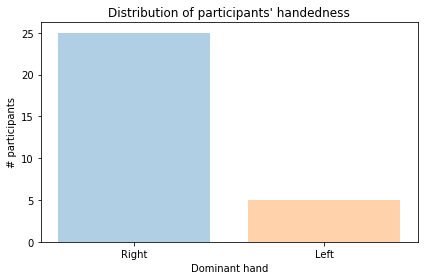

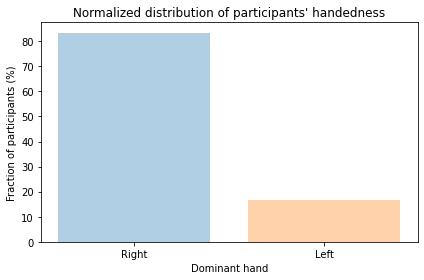

In [10]:
handedness = Counter(pre_df['D4'])
print_item_counts(handedness.items(), 'Dominant hand')

plt.figure()
plt.bar(handedness.keys(), handedness.values(), alpha=0.35, color=get_colors_list(len(handedness)))
plt.xlabel('Dominant hand')
plt.ylabel('# participants')
plt.title("Distribution of participants' handedness")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(handedness.keys(), np.array(list(handedness.values())) * 100 / len(pre_df), alpha=0.35, color=get_colors_list(len(handedness)))
plt.xlabel('Dominant hand')
plt.ylabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' handedness")
plt.tight_layout()
plt.show()


## 1.4 Relationship to co-diners

Each of 90 participants assessed their relationship with their 2 co-diners => 180 one-directional assessments<br>
In fact, they might not mutually agree.

### 1.4.1 Relationship type

Relationship type:
	Friend: 45 (75.00%)
	Other, please specify: 7 (11.67%)
	Partner: 4 (6.67%)
	Professional (co-worker/classmate): 4 (6.67%)
		 Co-worker of a friend
		 I don’t know these people
		 First time met
		 cohort
		 First time meet and eat together
		 I don’t know this person 
		 Friend of a friend


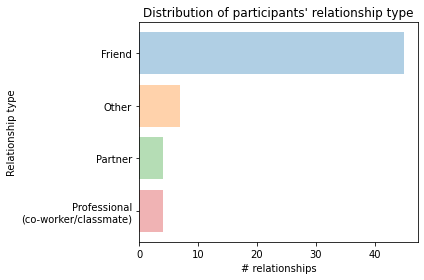

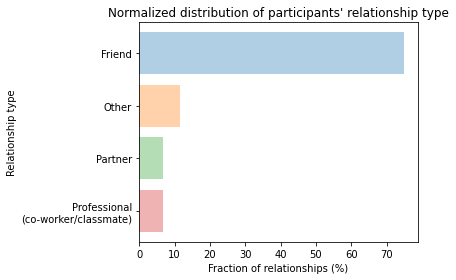

In [11]:
relationship_types = (Counter(pre_df['L1']) + Counter(pre_df['R1'])).most_common()[::-1]
print_item_counts(relationship_types[::-1], 'Relationship type')

for position in ['L', 'R']:
    for i, relationship in enumerate(pre_df[f'{position}1']):
        if relationship == 'Other, please specify':
            print(f"\t\t {pre_df[f'{position}1_4_TEXT'][i]}")

plt.figure()
plt.barh([f'{k.split(" ")[0]}\n{k.split(" ")[1]}' if len(k) > 22 else k.split(',')[0] for k, _ in relationship_types], [v for _, v in relationship_types], alpha=0.35, color=get_colors_list(len(relationship_types))[::-1])
plt.ylabel('Relationship type')
plt.xlabel('# relationships')
plt.title("Distribution of participants' relationship type")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh([f'{k.split(" ")[0]}\n{k.split(" ")[1]}' if len(k) > 22 else k.split(',')[0] for k, _ in relationship_types], 
         np.array([v for _, v in relationship_types]) * 100 / (2*len(pre_df)), alpha=0.35, color=get_colors_list(len(relationship_types))[::-1])
plt.ylabel('Relationship type')
plt.xlabel('Fraction of relationships (%)')
plt.title("Normalized distribution of participants' relationship type")
plt.tight_layout()
plt.show()


### 1.4.2 Relationship duration

Relationship duration:
	1 month - 1 year: 19 (31.67%)
	1 year - 2 years: 12 (20.00%)
	2 years - 5 years: 11 (18.33%)
	Less than 1 month: 10 (16.67%)
	More than 5 years: 8 (13.33%)


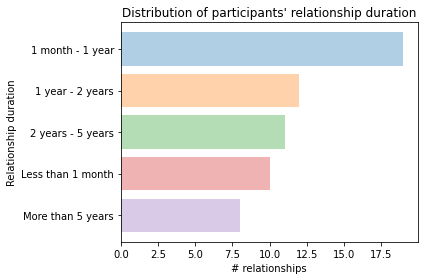

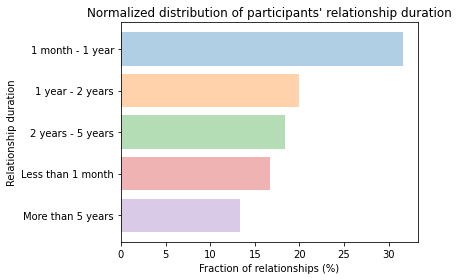

In [12]:
relationship_durations = Counter(pre_df['L2']) + Counter(pre_df['R2'])
relationship_durations = sorted(relationship_durations.items())
print_item_counts(relationship_durations, 'Relationship duration')

keys, values = zip(*relationship_durations[::-1])
plt.figure()
plt.barh(keys, values, alpha=0.35, color=get_colors_list(len(relationship_durations))[::-1])
plt.ylabel('Relationship duration')
plt.xlabel('# relationships')
plt.title("Distribution of participants' relationship duration")
plt.tight_layout()
plt.show()

keys, values = zip(*relationship_durations[::-1])
plt.figure()
plt.barh(keys, np.array(values) * 100 / (2*len(pre_df)), alpha=0.35, color=get_colors_list(len(relationship_durations))[::-1])
plt.ylabel('Relationship duration')
plt.xlabel('Fraction of relationships (%)')
plt.title("Normalized distribution of participants' relationship duration")
plt.tight_layout()
plt.show()


### 1.4.3 Frequency of eating together

Frequency of eating together:
	Several times a day: 4 (6.67%)
	Almost every day: 4 (6.67%)
	Few times a week: 14 (23.33%)
	Few times a month: 18 (30.00%)
	Few times a year: 9 (15.00%)
	Never
(this is the first time): 11 (18.33%)


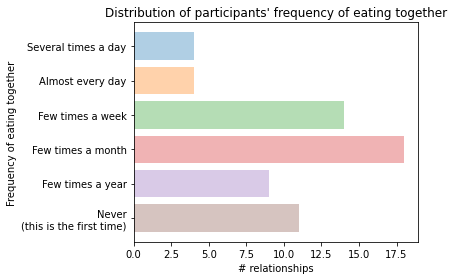

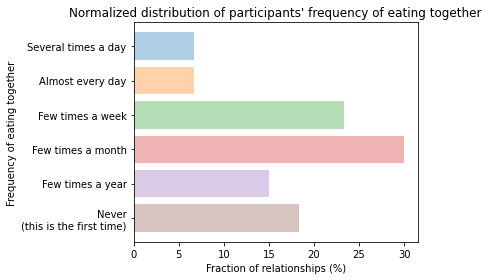

In [13]:
# Frequency of eating together (i.e. commensality frequency)
eating_together_freq = Counter(pre_df['L3']) + Counter(pre_df['R3'])
eating_together_freq = dict(sorted(eating_together_freq.items()))

# Shorten the longest key and impose key order
eating_together_freq['Never\n(this is the first time)'] = eating_together_freq['Never (this is the first time we are eating together)']
del eating_together_freq['Never (this is the first time we are eating together)']
eating_together_freq = { key : eating_together_freq[key] for key in ['Never\n(this is the first time)', 'Few times a year', 'Few times a month', 'Few times a week', 'Almost every day', 'Several times a day'] }
print_item_counts(list(eating_together_freq.items())[::-1], 'Frequency of eating together')

plt.figure()
plt.barh(list(eating_together_freq.keys()), eating_together_freq.values(), alpha=0.35, color=get_colors_list(len(eating_together_freq))[::-1])
plt.ylabel('Frequency of eating together')
plt.xlabel('# relationships')
plt.title("Distribution of participants' frequency of eating together")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(list(eating_together_freq.keys()), np.array(list(eating_together_freq.values())) * 100 / (2*len(pre_df)), alpha=0.35, color=get_colors_list(len(eating_together_freq))[::-1])
plt.ylabel('Frequency of eating together')
plt.xlabel('Fraction of relationships (%)')
plt.title("Normalized distribution of participants' frequency of eating together")
plt.tight_layout()
plt.show()


## 1.5 Social dining habits

### 1.5.1 Co-diner type

Co-diner type:
Breakfast:
	Alone: 22 (73.33%)
	Random people: 0 (0.00%)
	Co-workers: 0 (0.00%)
	Friends/roommates: 6 (20.00%)
	Family: 2 (6.67%)
	Other: 0 (0.00%)
Lunch:
	Alone: 10 (33.33%)
	Random people: 1 (3.33%)
	Co-workers: 10 (33.33%)
	Friends/roommates: 9 (30.00%)
	Family: 0 (0.00%)
	Other: 0 (0.00%)
Dinner:
	Alone: 8 (26.67%)
	Random people: 0 (0.00%)
	Co-workers: 0 (0.00%)
	Friends/roommates: 19 (63.33%)
	Family: 3 (10.00%)
	Other: 0 (0.00%)


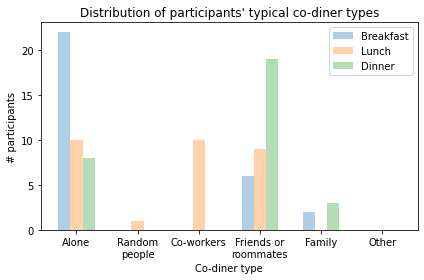

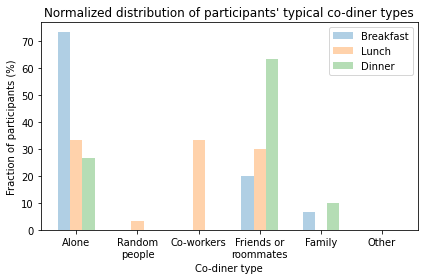

In [14]:
meal_types = ['Breakfast', 'Lunch', 'Dinner']
codiner_types = ['Alone', 'Random people', 'Co-workers', 'Friends/roommates', 'Family', 'Other, please specify']
codiner_types_labels = ['Alone', 'Random\npeople', 'Co-workers', 'Friends or\nroommates', 'Family', 'Other']
keys_range = np.arange(len(codiner_types))
ys = []
print('Co-diner type:')
plt.figure()
for i, meal_type in enumerate(meal_types):
    codiner_counter = Counter(pre_df[f'S1_{i + 1}'])
    # For the remaining types, impose key order and add zero counts
    codiner_counter_sorted = { codiner_type: 0 if codiner_type not in codiner_counter else codiner_counter[codiner_type] for codiner_type in codiner_types }
    # Rename the key for 'Other' co-diner types
    codiner_counter_sorted['Other'] = codiner_counter['Other, please specify']
    del codiner_counter_sorted['Other, please specify']
    print_item_counts(list(codiner_counter_sorted.items()), meal_type)

    # Show details of 'Other' co-diner types
    for j, codiner_type in enumerate(pre_df[f'S1_{i + 1}']):
        if codiner_type == 'Other, please specify':
            print(f"\t\t {pre_df[f'S1_{i + 1}_6_TEXT'][j]}")

    y = codiner_counter_sorted.values()
    ys.append(np.array(list(y)))
    plt.bar(keys_range + 0.2 * (i - 1), y, alpha=0.35, width=0.2, label=meal_type)
plt.xticks(keys_range, codiner_types_labels)
plt.xlabel('Co-diner type')
plt.ylabel('# participants')
plt.title("Distribution of participants' typical co-diner types")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for i, meal_type in enumerate(meal_types):
    plt.bar(keys_range + 0.2 * (i - 1), ys[i] * 100 / len(pre_df), alpha=0.35, width=0.2, label=meal_type)
plt.xticks(keys_range, codiner_types_labels)
plt.xlabel('Co-diner type')
plt.ylabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' typical co-diner types")
plt.legend()
plt.tight_layout()
plt.show()


### 1.5.2 Social dining frequency

Social dining frequency:
Breakfast:
 	 Min: 0 	 Max: 7 	 Mean: 1.9 	 Std: 2.413158373031769 	 Median: 1.0
Lunch:
 	 Min: 0 	 Max: 7 	 Mean: 3.7333333333333334 	 Std: 2.0483055327649624 	 Median: 3.0
Dinner:
 	 Min: 1 	 Max: 7 	 Mean: 4.6 	 Std: 2.169485346036397 	 Median: 4.5


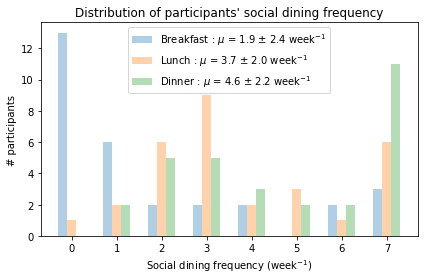

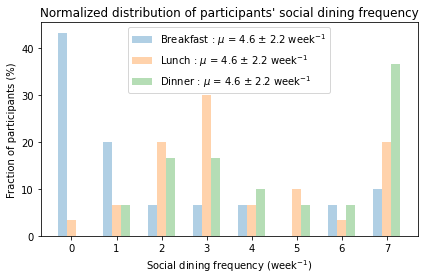

In [15]:
meal_types = ['Breakfast', 'Lunch', 'Dinner']
freq_range = np.arange(9)
print('Social dining frequency:')
ys = []
plt.figure()
for i, meal_type in enumerate(meal_types):
    sd_freq = pd.to_numeric(pre_df[f'S2_{i + 1}'])
    print_array_stats(sd_freq, meal_type)
    y = np.histogram(sd_freq, bins=freq_range)[0]
    ys.append(y)
    plt.bar(freq_range[:-1] + 0.2 * (i - 1), y, alpha=0.35, width=0.2, label=fr'{meal_type} : $\mu$ = {np.mean(sd_freq):.1f} $\pm$ {np.std(sd_freq):.1f} week$^{{-1}}$')
plt.legend()
plt.xlabel(fr'Social dining frequency (week$^{{-1}}$)')
plt.ylabel('# participants')
plt.title("Distribution of participants' social dining frequency")
plt.tight_layout()
plt.show()

plt.figure()
for i, meal_type in enumerate(meal_types):
    plt.bar(freq_range[:-1] + 0.2 * (i - 1), ys[i] * 100 / len(pre_df), alpha=0.35, width=0.2, label=fr'{meal_type} : $\mu$ = {np.mean(sd_freq):.1f} $\pm$ {np.std(sd_freq):.1f} week$^{{-1}}$')
plt.legend()
plt.xlabel(fr'Social dining frequency (week$^{{-1}}$)')
plt.ylabel('Fraction of participants (%)')
plt.title("Normalized distribution of participants' social dining frequency")
plt.tight_layout()
plt.show()


### 1.5.3 Dining location

Dining location:
Breakfast:
	At home: 27 (90.00%)
	At restaurant: 1 (3.33%)
	At work: 1 (3.33%)
	Other: 1 (3.33%)
		 I don’t eat breakfast 
Lunch:
	At home: 9 (30.00%)
	At restaurant: 0 (0.00%)
	At work: 21 (70.00%)
	Other: 0 (0.00%)
Dinner:
	At home: 23 (76.67%)
	At restaurant: 2 (6.67%)
	At work: 5 (16.67%)
	Other: 0 (0.00%)


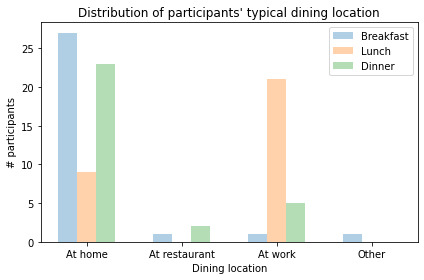

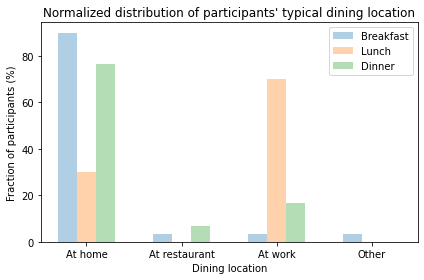

In [16]:
meal_types = ['Breakfast', 'Lunch', 'Dinner']
keys_range = np.arange(4)
locations = ['At home', 'At restaurant', 'At work', 'Other']
print('Dining location:')
ys = []
plt.figure()
for i, meal_type in enumerate(meal_types):
    dining_loc_counter = Counter(pre_df[f'S3_{i + 1}'])
    # Rename the key for 'Other' dining locations
    dining_loc_counter['Other'] = dining_loc_counter['Other, please specify']
    del dining_loc_counter['Other, please specify']
    for location in locations:
        if location not in dining_loc_counter:
            dining_loc_counter[location] = 0
    dining_loc = sorted(dining_loc_counter.items())
    print_item_counts(dining_loc, meal_type)

    # Show details of 'Other' co-diner types
    for j, codiner_type in enumerate(pre_df[f'S3_{i + 1}']):
        if codiner_type == 'Other, please specify':
            print(f"\t\t {pre_df[f'S3_{i + 1}_4_TEXT'][j]}")

    y = [v for _, v in dining_loc]
    ys.append(np.array(y))
    plt.bar(keys_range + 0.2 * (i - 1), y, width=0.2, alpha=0.35, label=meal_type)
plt.xticks(keys_range, locations)
plt.xlabel('Dining location')
plt.ylabel('# participants')
plt.legend()
plt.title("Distribution of participants' typical dining location")
plt.tight_layout()
plt.show()

plt.figure()
for i, meal_type in enumerate(meal_types):
    plt.bar(keys_range + 0.2 * (i - 1), ys[i] * 100 / len(pre_df), width=0.2, alpha=0.35, label=meal_type)
plt.xticks(keys_range, locations)
plt.xlabel('Dining location')
plt.ylabel('Fraction of participants (%)')
plt.legend()
plt.title("Normalized distribution of participants' typical dining location")
plt.tight_layout()
plt.show()


## 1.6 Permission to present identifiable data

In [17]:
permission_types = {
    'I grant full permission for the use of audio and video recordings as described above.': 'Full permission',
    'I grant permission provided that my face is de-identified.': 'Face must be de-identified',
    'I decline this optional permission.': 'Declined'
}

print('Permission to present identifiable data')
permissions_df = pd.DataFrame().assign(Participant_ID=pre_df['I2'] + '_' + pre_df['I3'], 
                                       Permission=pre_df['Q1'].apply(lambda x: permission_types[x]),
                                       Permission_Full=pre_df['Q1']
                                      )
permissions_df


Permission to present identifiable data


,Participant_ID,Permission,Permission_Full
0,01_1 (with the robot),Full permission,I grant full permission for the use of audio a...
1,01_2,Full permission,I grant full permission for the use of audio a...
2,01_3,Full permission,I grant full permission for the use of audio a...
3,02_1 (with the robot),Face must be de-identified,I grant permission provided that my face is de...
4,02_2,Full permission,I grant full permission for the use of audio a...
5,02_3,Full permission,I grant full permission for the use of audio a...
6,03_1 (with the robot),Full permission,I grant full permission for the use of audio a...
7,03_2,Face must be de-identified,I grant permission provided that my face is de...
8,03_3,Face must be de-identified,I grant permission provided that my face is de...
9,04_1 (with the robot),Face must be de-identified,I grant permission provided that my face is de...


In [18]:
# Print out the permissions for copy to the User Study Participants & Design sheet with participants
print(*permissions_df['Permission'], sep='\n')


Full permission
Full permission
Full permission
Face must be de-identified
Full permission
Full permission
Full permission
Face must be de-identified
Face must be de-identified
Face must be de-identified
Face must be de-identified
Face must be de-identified
Full permission
Full permission
Face must be de-identified
Full permission
Full permission
Full permission
Full permission
Full permission
Full permission
Full permission
Full permission
Full permission
Full permission
Full permission
Face must be de-identified
Full permission
Face must be de-identified
Full permission


## 1.7 Level of hunger

Level of participant hunger::
 	 Min: 2 	 Max: 4 	 Mean: 3.1333333333333333 	 Std: 0.669991708074726 	 Median: 3.0
Level of participant hunger::
	1: 0 (0.00%)
	2: 5 (16.67%)
	3: 16 (53.33%)
	4: 9 (30.00%)
	5: 0 (0.00%)


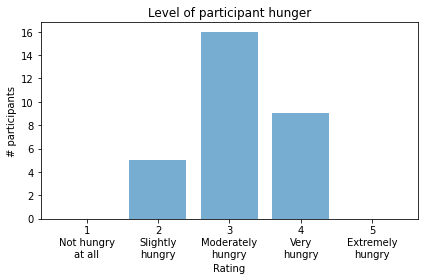

In [19]:
prompt = 'Please rate your level of hunger'

hunger_level_labels = [
    '1\nNot hungry\nat all',
    '2\nSlightly\nhungry',
    '3\nModerately\nhungry',
    '4\nVery\nhungry',
    '5\nExtremely\nhungry'
]

hunger_level_range = np.arange(1, 1 + len(hunger_level_labels))
hunger_level_counter = Counter([int(x[0]) for x in pre_df['H1']])
for hunger_level in hunger_level_range:
    if hunger_level not in hunger_level_counter:
        hunger_level_counter[hunger_level] = 0

print_array_stats([int(x[0]) for x in pre_df['H1']], 'Level of participant hunger:')
print_item_counts(sorted(hunger_level_counter.items()), 'Level of participant hunger:')

plt.figure()
plt.bar(hunger_level_counter.keys(), hunger_level_counter.values(), alpha=0.6)
plt.xticks(hunger_level_range, hunger_level_labels)
plt.xlabel('Rating')
plt.ylabel('# participants')
plt.title(f'Level of participant hunger')
plt.tight_layout()
plt.show()


# 2 Experiment questionnaire

## 2.1 Data validation

In [20]:
assert all(exp_df['Progress'] == '100')
assert all(exp_df['Finished'] == 'True')
for i in range(len(exp_df) // 3):
    for j in range(3):
        # Session ID
        assert exp_df['I1'][i * 3 + j] == f'{i + 1:02d}', f"{i}_{j}: {exp_df['I1'][i * 3 + j]} != {i + 1:02d}"
        # Participant position
        assert exp_df['I2'][i * 3 + j][:1] == f'{j + 1:01d}', f"{i}_{j}: {exp_df['I2'][i * 3 + j]} != {j + 1:01d}"


## 2.2 Bite timing strategy comparison: Fixed-Interval, Mouth-Open, Learned

In [21]:
condition_labels = {
    'a': 'Fixed-Interval', 
    'b': 'Mouth-Open', 
    'c': 'Learned'
}

# sessions x trials
# Drop the session id column
study_conditions = conditions_df.to_numpy()[:len(exp_df) // 3, 1:]
study_conditions

array([['a', 'b', 'c', 'b', 'a', 'c', 'a', 'b', 'c', 'a'],
       ['b', 'a', 'b', 'a', 'c', 'a', 'c', 'b', 'c', 'b'],
       ['a', 'b', 'a', 'b', 'c', 'b', 'c', 'a', 'c', 'a'],
       ['c', 'a', 'b', 'c', 'a', 'b', 'a', 'c', 'b', 'c'],
       ['c', 'b', 'c', 'b', 'a', 'c', 'a', 'b', 'a', 'c'],
       ['b', 'a', 'c', 'b', 'a', 'c', 'a', 'b', 'c', 'b'],
       ['a', 'b', 'c', 'b', 'a', 'c', 'a', 'c', 'b', 'a'],
       ['a', 'c', 'a', 'c', 'b', 'c', 'b', 'a', 'b', 'a'],
       ['c', 'b', 'a', 'b', 'c', 'a', 'c', 'a', 'b', 'c'],
       ['b', 'c', 'a', 'b', 'c', 'b', 'a', 'c', 'a', 'b']], dtype=object)

### 2.2.1 Forced choice - bite timing appropriateness

#### 2.2.1.1 Overall/three-way comparison

In [26]:
relative_target_ratings = {'a': 0, 'b': 0, 'c': 0}
relative_codiner_ratings = {'a': 0, 'b': 0, 'c': 0}
relative_overall_ratings = {'a': 0, 'b': 0, 'c': 0}

for trial in range(2, 11):
    ratings = [ rating for rating in exp_df[f'T{trial}-1-compare'] ]

    for session_idx, trial_condition in enumerate(study_conditions[:len(ratings)//3, trial - 1]):
        prev_trial_condition = study_conditions[session_idx, trial - 2]
        
        relative_target_ratings[trial_condition  if ratings[session_idx*3]     == 'This trial' else prev_trial_condition] += 1
        relative_codiner_ratings[trial_condition if ratings[session_idx*3 + 1] == 'This trial' else prev_trial_condition] += 1
        relative_codiner_ratings[trial_condition if ratings[session_idx*3 + 2] == 'This trial' else prev_trial_condition] += 1

        relative_overall_ratings[trial_condition if ratings[session_idx*3]     == 'This trial' else prev_trial_condition] += 1
        relative_overall_ratings[trial_condition if ratings[session_idx*3 + 1] == 'This trial' else prev_trial_condition] += 1
        relative_overall_ratings[trial_condition if ratings[session_idx*3 + 2] == 'This trial' else prev_trial_condition] += 1

assert sum(relative_target_ratings.values()) == (study_conditions.shape[1] - 1) * len(exp_df)//3
assert sum(relative_codiner_ratings.values()) == 2 * (study_conditions.shape[1] - 1) * len(exp_df)//3
   

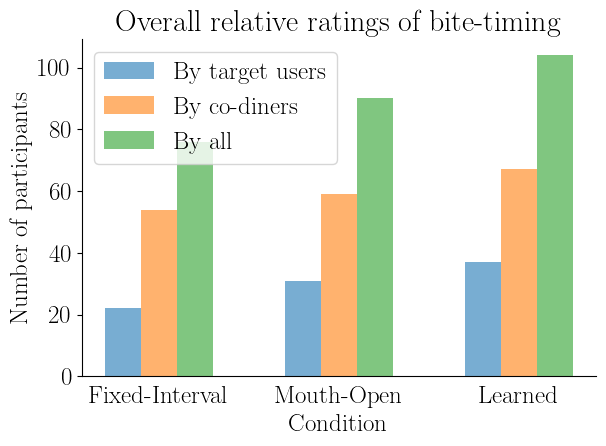

In [196]:
# Group by strategy

plt.figure()
bin_width = 0.2
for i, (rater_label, ratings) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [relative_target_ratings, relative_codiner_ratings, relative_overall_ratings])): 
    y = [ratings[condition] for condition in condition_labels.keys()]
    x_pos = [x + (i - 1.5)*bin_width for x in range(3) ]
    plt.bar(x_pos, y, width=bin_width, align='edge', label=rater_label, alpha=0.6)

plt.xticks(np.arange(3), condition_labels.values())
plt.xlabel('Condition')
plt.ylabel('Number of participants')
plt.legend()
plt.title('Overall relative ratings of bite-timing')
plt.tick_params(bottom=False)
plt.tight_layout()
plt.show()


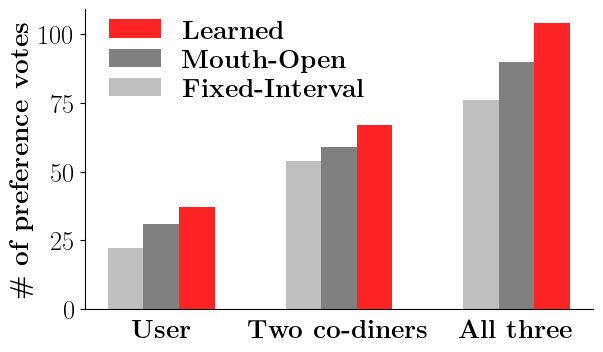

In [27]:
# Group by rater type (target/codiners/all)

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
bin_width = 0.2
ys = []
x_pos = []
for i, (rater_label, ratings) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [relative_target_ratings, relative_codiner_ratings, relative_overall_ratings])): 
    ys.extend( [ratings[condition] for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 3.9))
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y) in enumerate(zip(x_pos[3*i:3*i+3], ys[i::3])):
        if remove_all_diners and j == 2: break
        plt.bar(x, y, width=bin_width, align='edge', label=boldit(condition) if j == 0 else None, color=colors[i])
plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylabel(boldit("\# of preference votes"))
plt.legend(frameon=False, labelspacing=-2, loc='upper left', bbox_to_anchor=(0.0, 0.85))
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_strategies.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.1.2 Pair-wise comparison

In [28]:
comparison_types = ['ab', 'ac', 'bc']
relative_target_ratings = { comparison_type: {condition: 0 for condition in comparison_type} for comparison_type in comparison_types }
relative_codiner_ratings = { comparison_type: {condition: 0 for condition in comparison_type} for comparison_type in comparison_types }
relative_overall_ratings = { comparison_type: {condition: 0 for condition in comparison_type} for comparison_type in comparison_types }

for trial in range(2, 11):
    ratings = [ rating for rating in exp_df[f'T{trial}-1-compare'] ]

    for session_idx, trial_condition in enumerate(study_conditions[:len(ratings)//3, trial - 1]):
        prev_trial_condition = study_conditions[session_idx, trial - 2]
        
        comparison_type = trial_condition + prev_trial_condition if trial_condition < prev_trial_condition else prev_trial_condition + trial_condition
        
        relative_target_ratings[comparison_type][trial_condition  if ratings[session_idx*3]     == 'This trial' else prev_trial_condition] += 1
        relative_codiner_ratings[comparison_type][trial_condition if ratings[session_idx*3 + 1] == 'This trial' else prev_trial_condition] += 1
        relative_codiner_ratings[comparison_type][trial_condition if ratings[session_idx*3 + 2] == 'This trial' else prev_trial_condition] += 1

        relative_overall_ratings[comparison_type][trial_condition if ratings[session_idx*3]     == 'This trial' else prev_trial_condition] += 1
        relative_overall_ratings[comparison_type][trial_condition if ratings[session_idx*3 + 1] == 'This trial' else prev_trial_condition] += 1
        relative_overall_ratings[comparison_type][trial_condition if ratings[session_idx*3 + 2] == 'This trial' else prev_trial_condition] += 1


In [29]:
relative_target_ratings, relative_codiner_ratings

({'ab': {'a': 13, 'b': 17}, 'ac': {'a': 9, 'c': 21}, 'bc': {'b': 14, 'c': 16}},
 {'ab': {'a': 30, 'b': 30},
  'ac': {'a': 24, 'c': 36},
  'bc': {'b': 29, 'c': 31}})

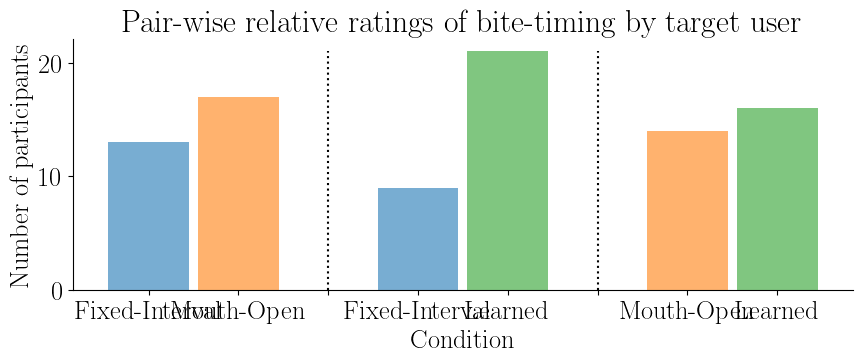

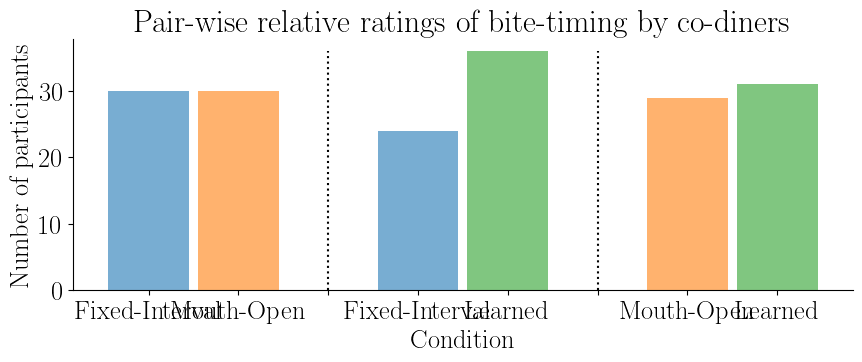

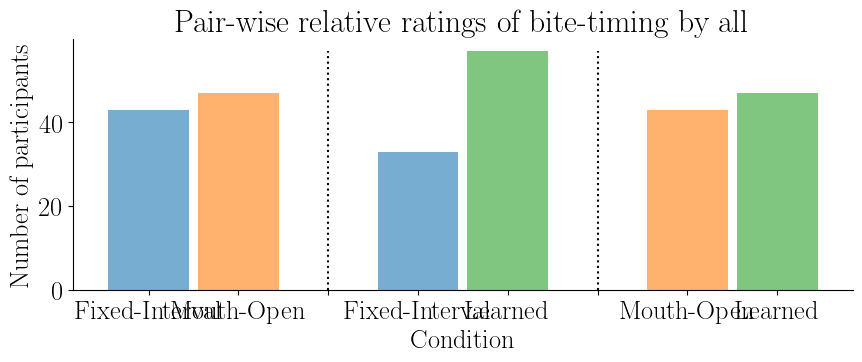

In [30]:
titles = ['Pair-wise relative ratings of bite-timing by target user', 
          'Pair-wise relative ratings of bite-timing by co-diners',
          'Pair-wise relative ratings of bite-timing by all'
         ]

for ratings_data, title in zip([relative_target_ratings, relative_codiner_ratings, relative_overall_ratings], titles):
    plt.figure(figsize=(9, 4))
    bin_width = 0.9

    x_pos = [0, 1, 3, 4, 6, 7]
    y = [ratings_data[comparison_type][condition] for comparison_type in comparison_types for condition in comparison_type]
    colors_list = get_colors_list(3)
    colors = [colors_list[0], colors_list[1], colors_list[0], colors_list[2], colors_list[1], colors_list[2]]

    plt.bar(x_pos, y, width=bin_width, align='center', alpha=0.6, color=colors)
    plt.vlines(2, 0, max(y), linestyles ="dotted", colors ="k")
    plt.vlines(5, 0, max(y), linestyles ="dotted", colors ="k")

    plt.xticks(np.arange(8), [condition_labels['a'], condition_labels['b'], '', condition_labels['a'], condition_labels['c'], '', condition_labels['b'], condition_labels['c']])
    plt.xlabel('Condition')
    plt.ylabel('Number of participants')
    plt.title(title)
    plt.tight_layout()
    plt.show()

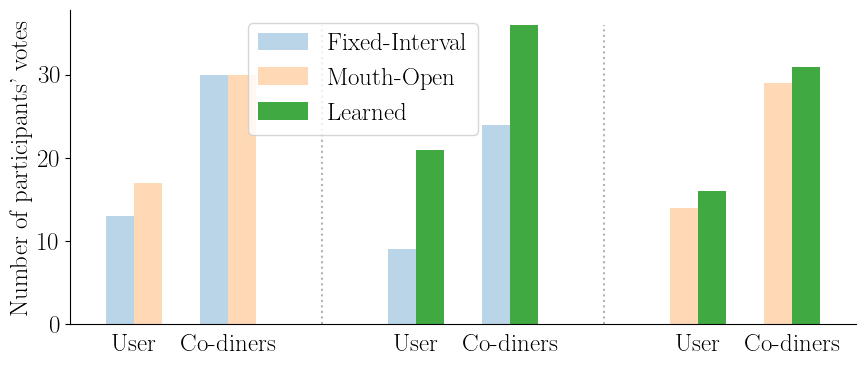

In [31]:
# Grouop by rater type (target/codiners)

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 18, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

bin_width = 0.3
x_pos = np.array([x for i in range(6) for x in (i - bin_width, i)])
x_pos[4:] += 1
x_pos[8:] += 1
ys = []
for ratings_data, title in zip([relative_target_ratings, relative_codiner_ratings], titles):
    ys.extend([ratings_data[comparison_type][condition] for comparison_type in comparison_types for condition in comparison_type])
ys = np.array(ys)

conditions = [ condition for comparison_type in comparison_types for comparison_type_i in [comparison_type, comparison_type] for condition in comparison_type_i ]

colors_list = get_colors_list(3)
colors = {
    'a': colors_list[0], 'b': colors_list[1], 'c': colors_list[2]
}
alphas = np.array([0.3] * 12)
alphas[[5, 7, 9, 11]] = 0.9

plt.figure(figsize=(9, 4))
for i, y in enumerate(ys[[0, 1, 6, 7, 2, 3, 8, 9, 4, 5, 10, 11]]):
    label = None
    if i == 0: label = condition_labels['a']
    if i == 1: label = condition_labels['b']
    if i == 5: label = condition_labels['c']
        
    plt.bar(x_pos[i], y, width=bin_width, align='edge', alpha=alphas[i], label=label, color=colors[conditions[i]])

plt.vlines(2, 0, max(ys), linestyles ="dotted", colors ="k", alpha=0.3)
plt.vlines(5, 0, max(ys), linestyles ="dotted", colors ="k", alpha=0.3)
xlabels = ['User', 'Co-diners'] * 3
xlabels_pos = [0, 1, 3, 4, 6, 7]
plt.xticks(xlabels_pos, xlabels)
plt.ylabel("Number of participants' votes")
plt.tick_params(bottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(0.21, 1))
plt.tight_layout()
plt.savefig("results_strategies_ext.pdf", format="pdf", bbox_inches="tight")
plt.show()

### 2.2.2 By all other factors:
- Bite timing appropriateness (absolute rating)
- Distraction by the robot
- Ability to have natural conversations
- Ability to feel comfortable around the robot
- System reliability
- Ability to trust the system
- Overall experience of the meal
- Social interactions with the other participants

In [ ]:
prompts = {
    '1': 'Please rate how timely the robot assisted with feeding',
    '2_1': 'I felt distracted by the robot',
    '2_2': 'I was able to have a natural conversation with the group',
    '2_3': 'I felt comfortable around the robot',
    '2_4': 'The system is reliable',
    '2_5': 'I can trust the system',
    '3_1': 'My overall experience of the meal was great',
    '3_2': 'I liked the social interactions with the other participants very much'
}

target_ratings = {}
codiner_ratings = {}
overall_ratings = {}

for prompt_key in prompts.keys():
    target_ratings[prompt_key] = {'a': [], 'b': [], 'c': []}
    codiner_ratings[prompt_key] = {'a': [], 'b': [], 'c': []}
    overall_ratings[prompt_key] = {'a': [], 'b': [], 'c': []}

    for trial in range(1, 11):
        ratings = [ int(rating[0]) for rating in exp_df[f'T{trial}-{prompt_key}'] ]

        for session_idx, trial_condition in enumerate(study_conditions[:len(ratings)//3, trial - 1]):
            target_ratings[prompt_key][trial_condition].append( ratings[session_idx*3] )
            codiner_ratings[prompt_key][trial_condition].extend( [ratings[session_idx*3 + 1], ratings[session_idx*3 + 2]] )
            overall_ratings[prompt_key][trial_condition].extend( [ratings[session_idx*3], ratings[session_idx*3 + 1], ratings[session_idx*3 + 2]] )


Please rate how timely the robot assisted with feeding


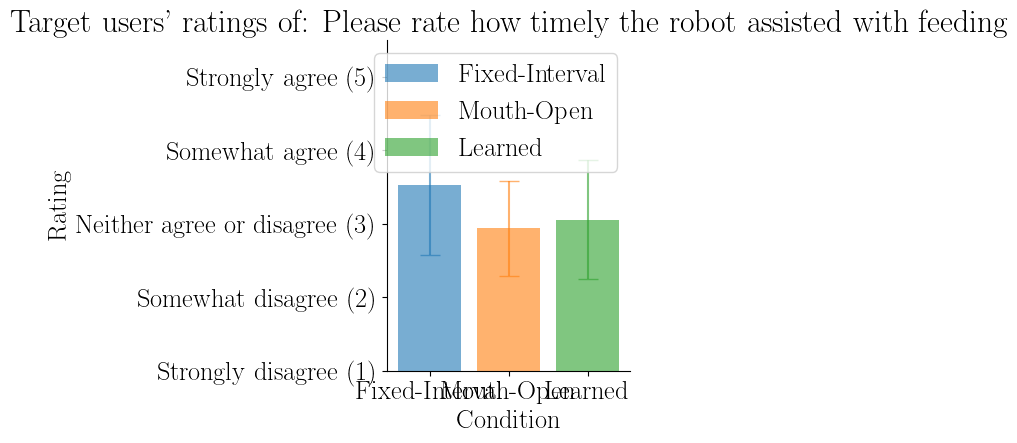

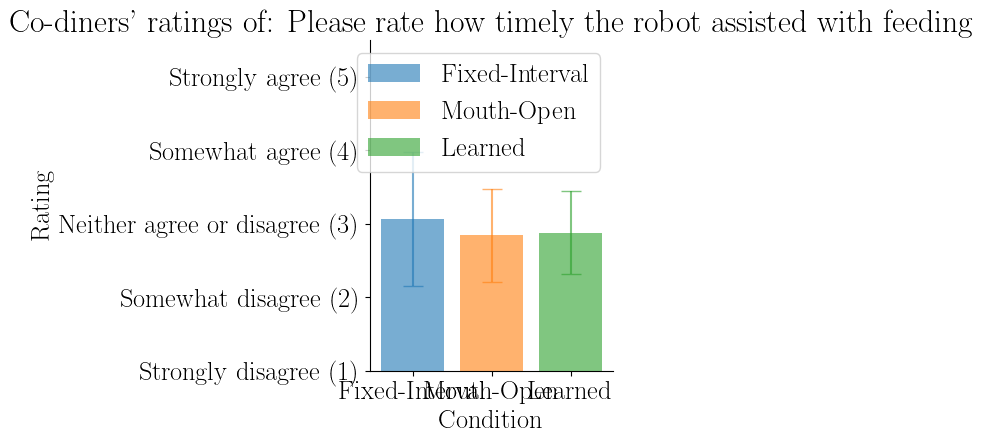

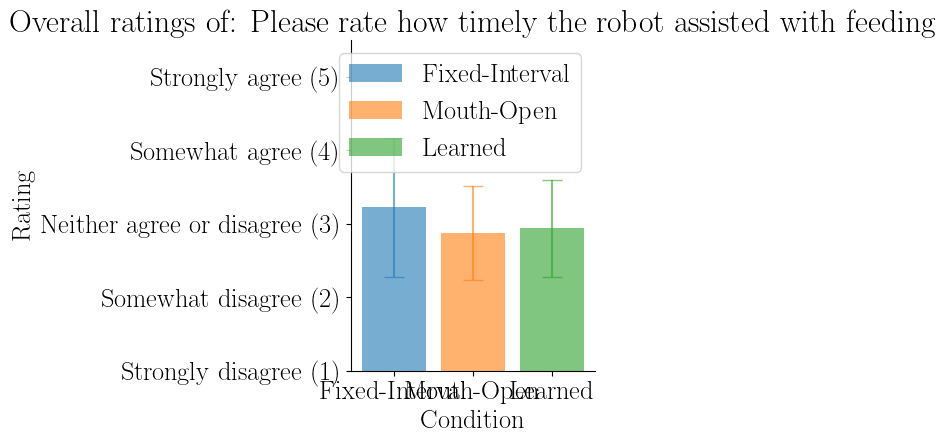

I felt distracted by the robot


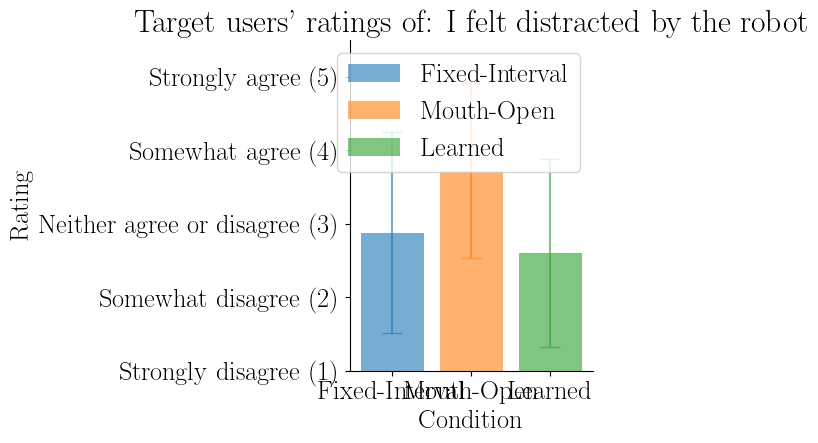

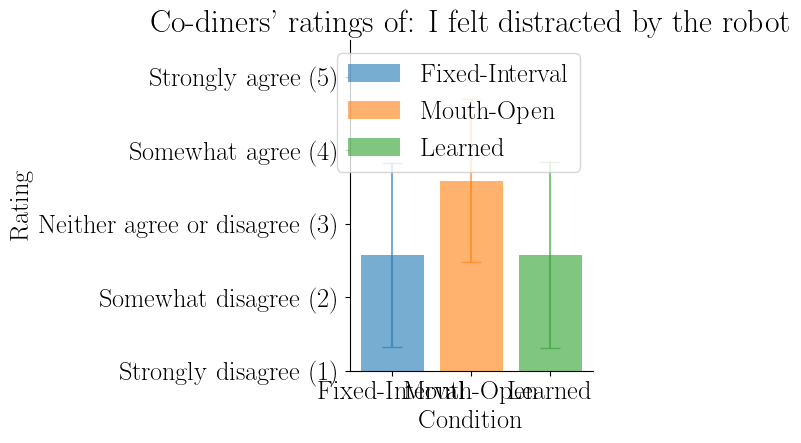

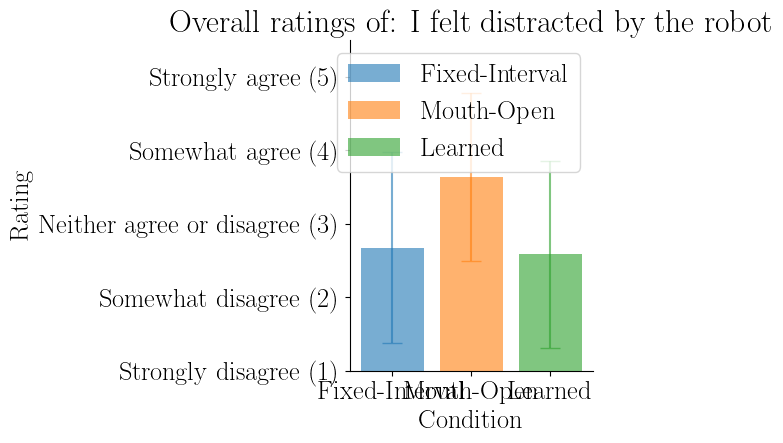

I was able to have a natural conversation with the group


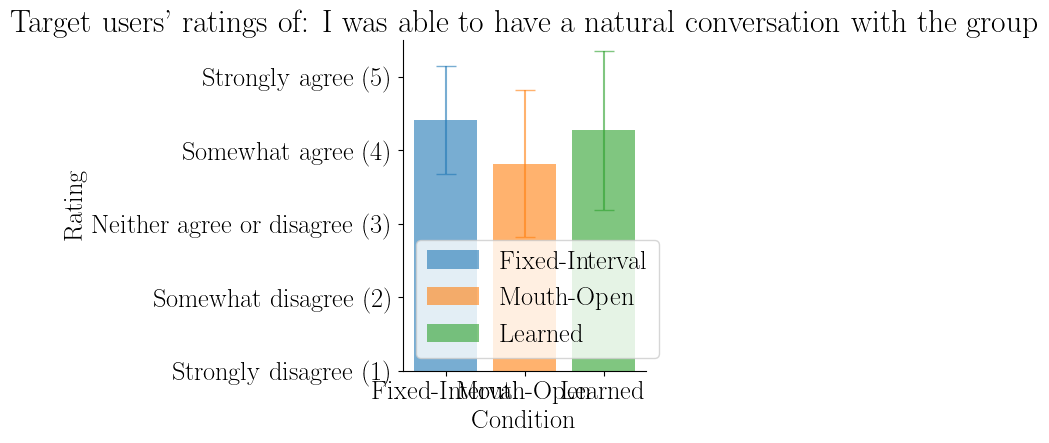

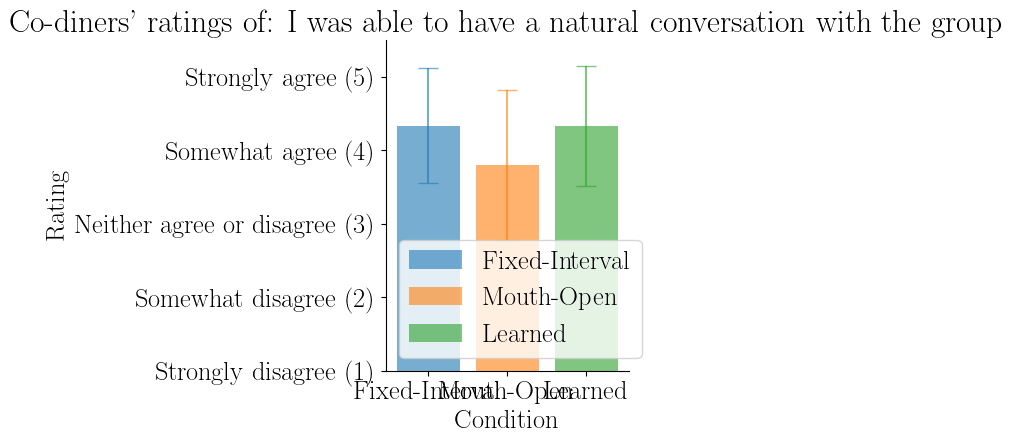

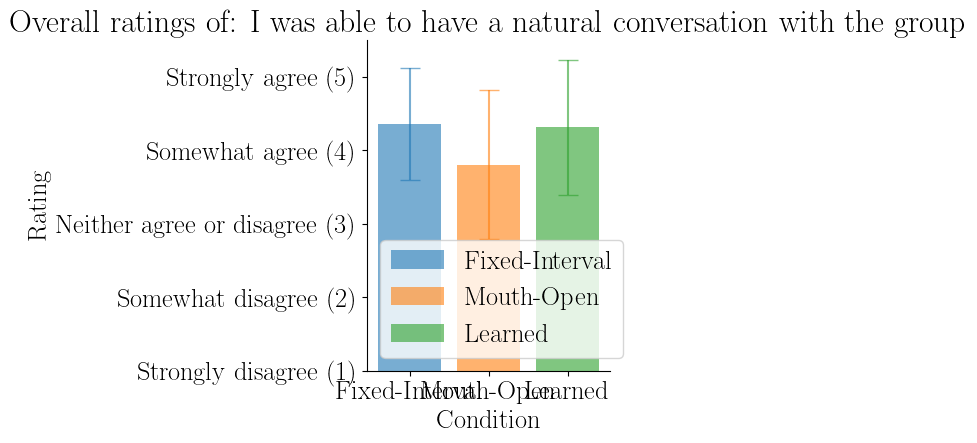

I felt comfortable around the robot


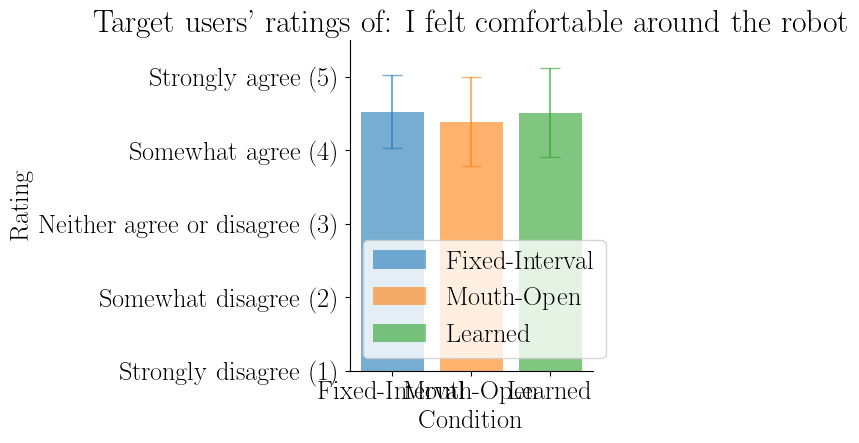

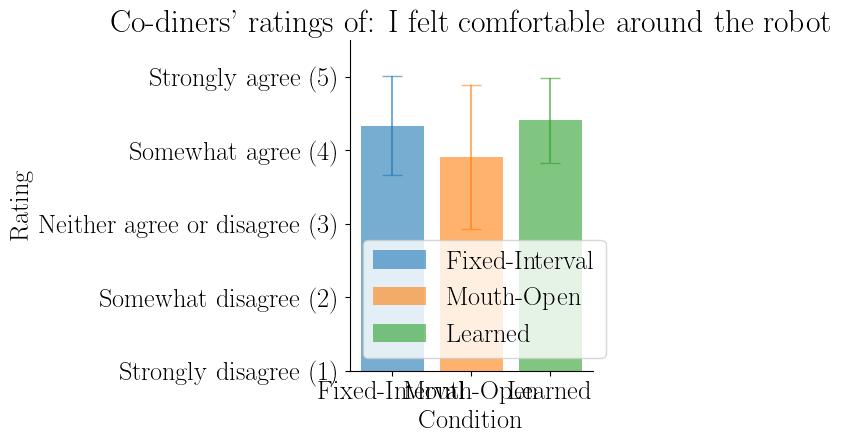

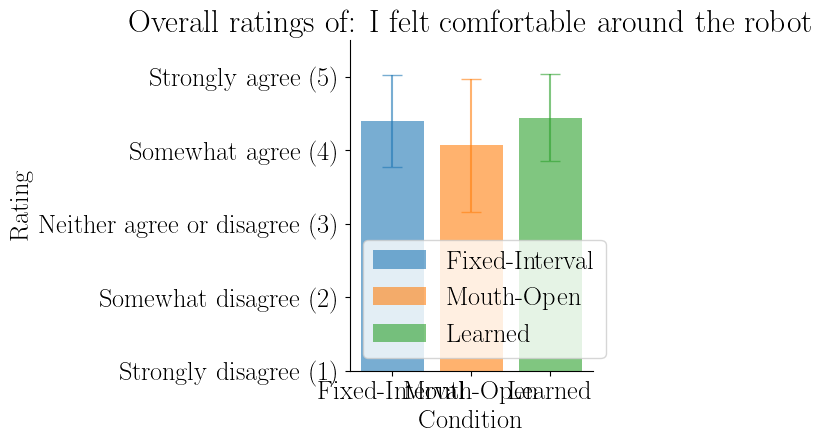

The system is reliable


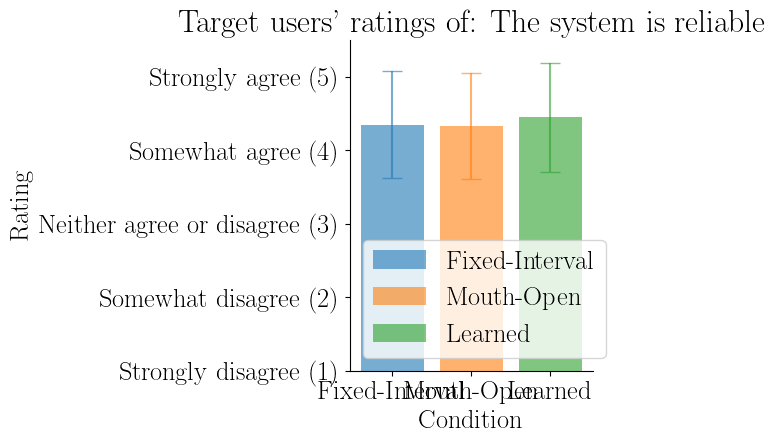

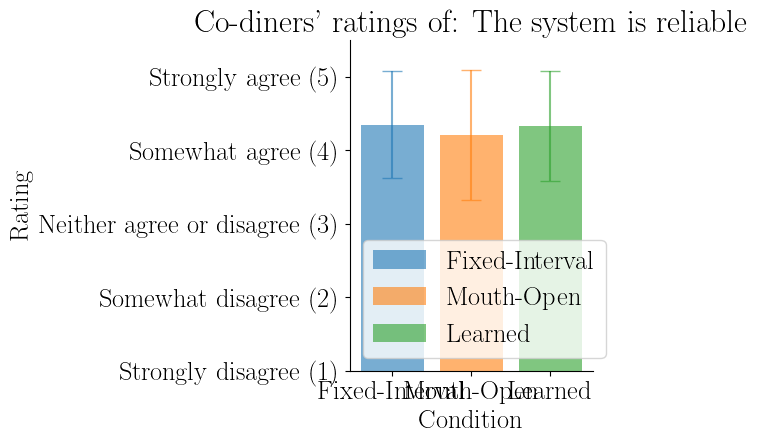

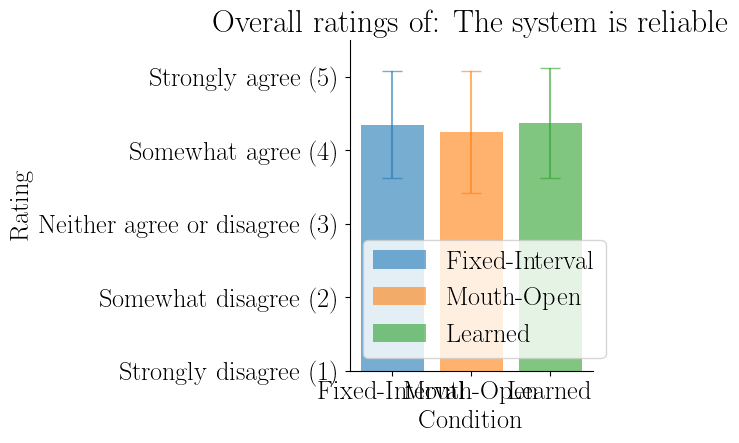

I can trust the system


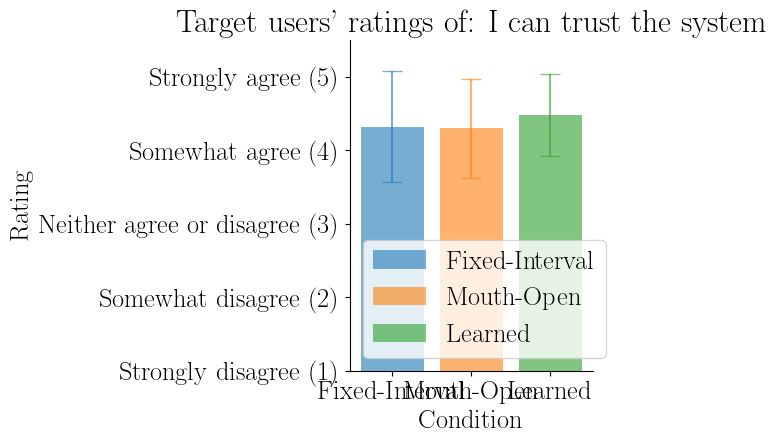

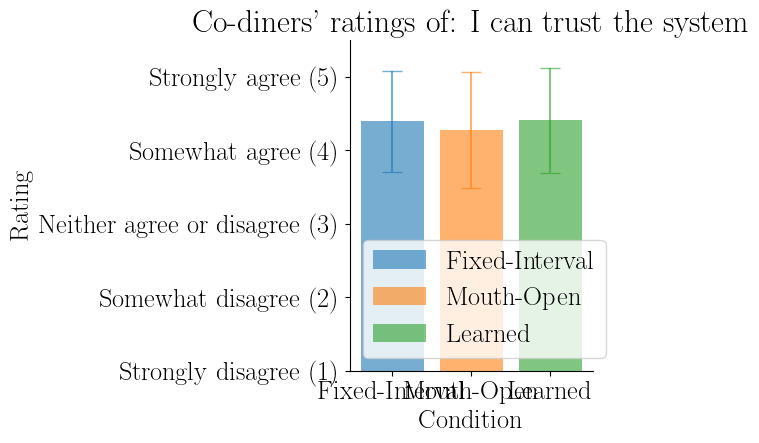

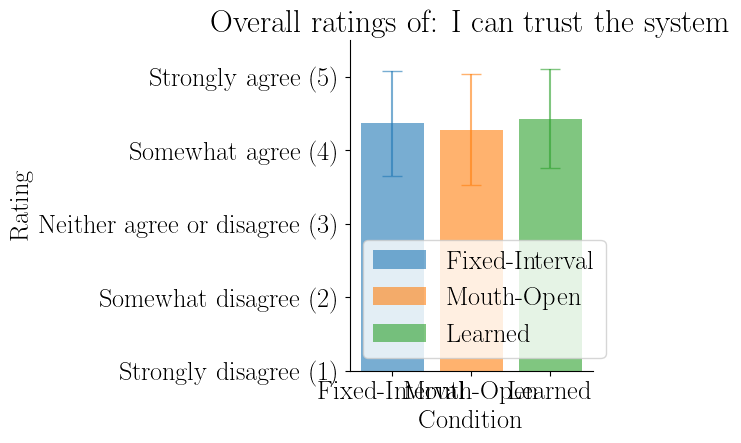

My overall experience of the meal was great


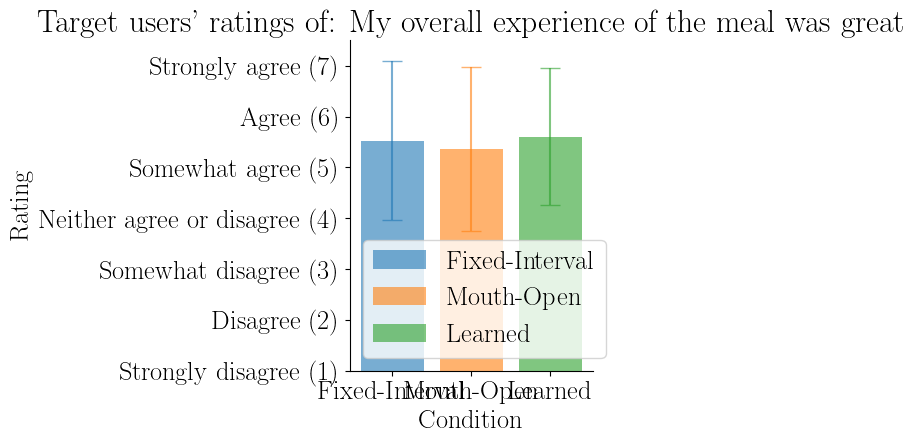

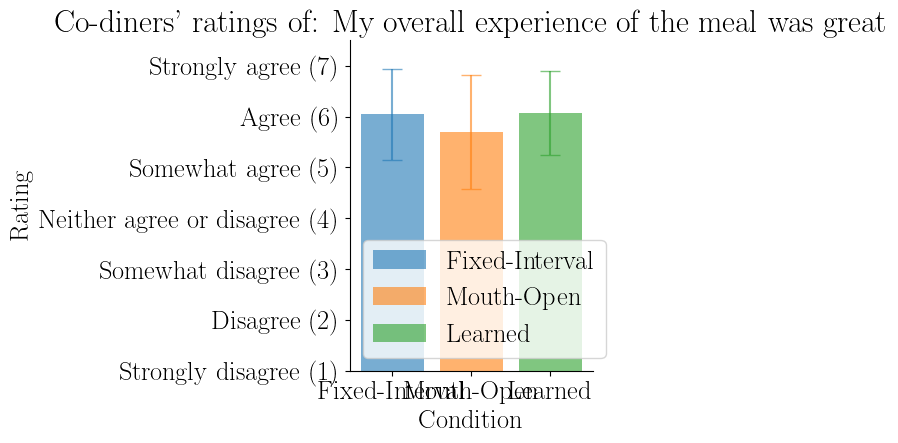

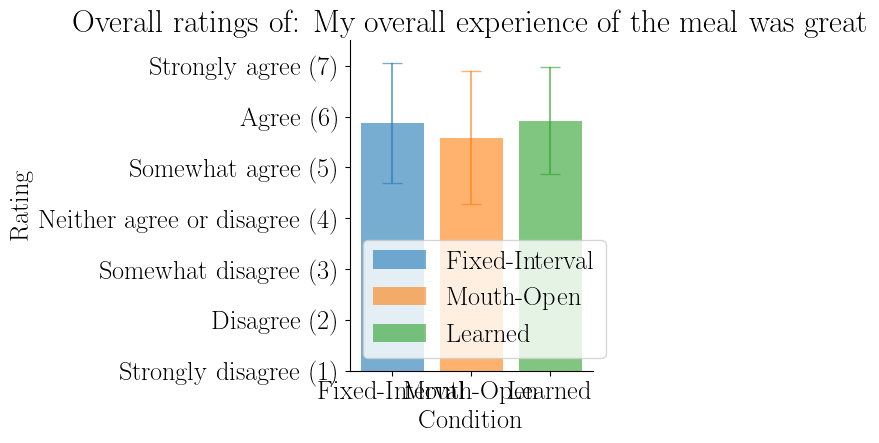

I liked the social interactions with the other participants very much


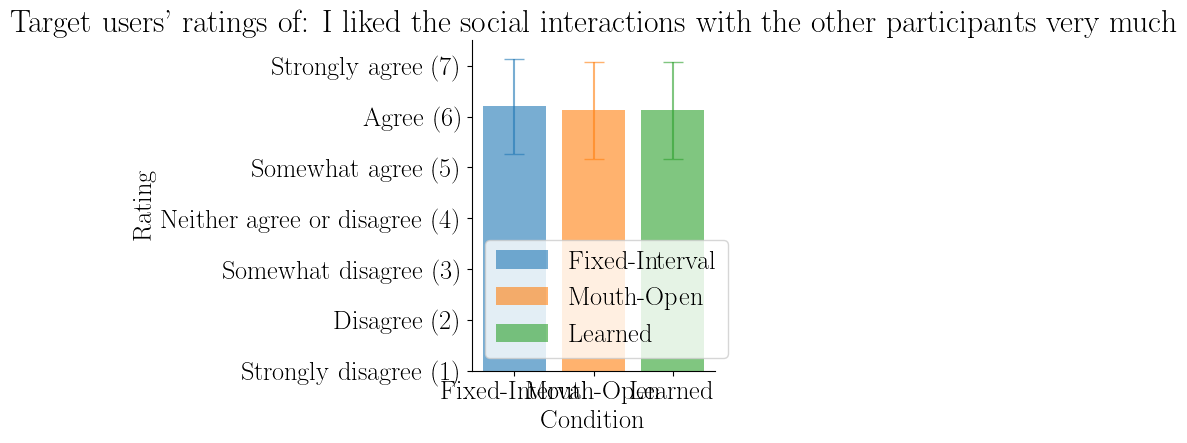

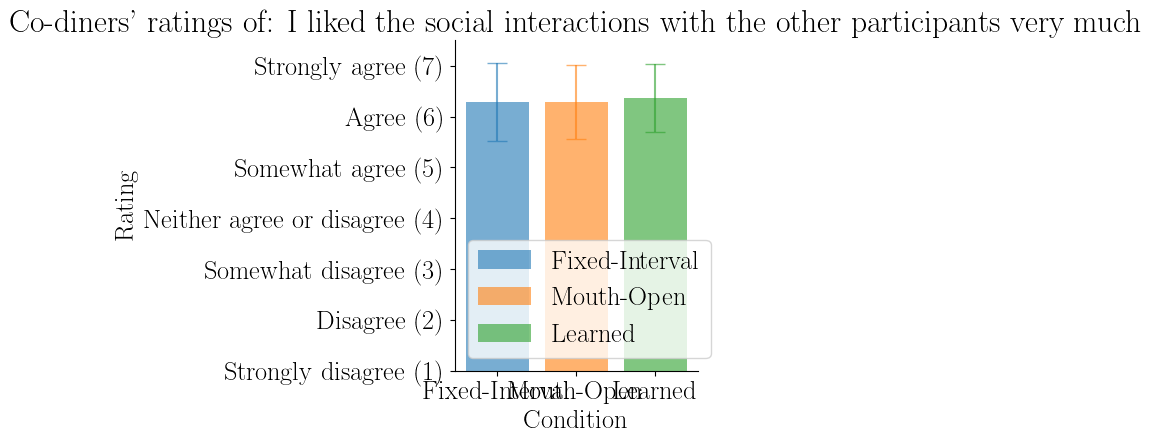

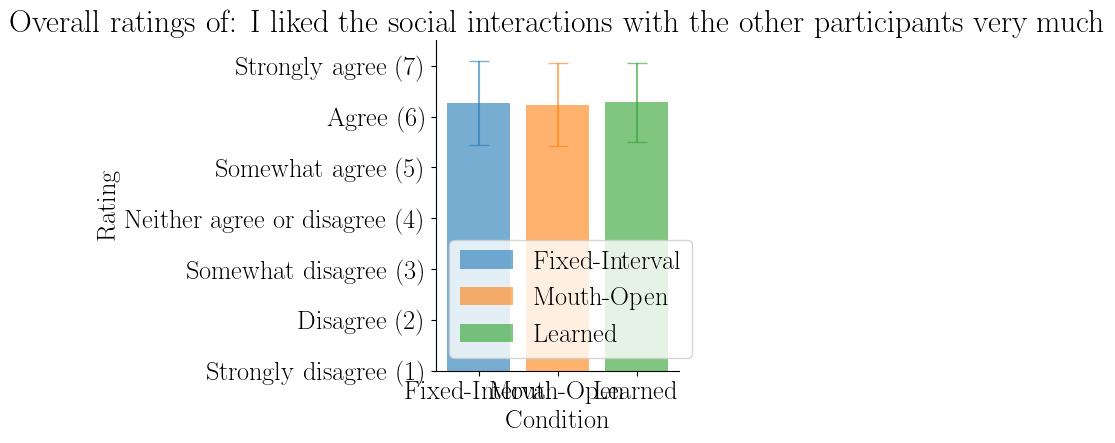

In [43]:
# Bar and box plots for each factor

# rating_labels = ['1\nStrongly disagree', '2\nSomewhat disagree', '3\nNeither agree\nor disagree', '4\nSomewhat agree', '5\nStrongly agree']
rating_labels = ['Strongly disagree (1)', 'Somewhat disagree (2)', 'Neither agree or disagree (3)', 'Somewhat agree (4)', 'Strongly agree (5)']
rating_labels7 = ['Strongly disagree (1)', 'Disagree (2)', 'Somewhat disagree (3)', 'Neither agree or disagree (4)', 'Somewhat agree (5)', 'Agree (6)', 'Strongly agree (7)']
num_ratings = 5

for prompt_key in prompts.keys():
    print(prompts[prompt_key])
    if prompt_key[0] == '3':
        rating_labels = rating_labels7
        num_ratings = 7
    
    titles = [f"Target users' ratings of: {prompts[prompt_key]}", 
              f"Co-diners' ratings of: {prompts[prompt_key]}",
              f"Overall ratings of: {prompts[prompt_key]}",
             ]
    for ratings_data, title in zip([target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]], titles):
        alpha = 0.6
        err_kw = dict(alpha=alpha, capsize=7, capthick=None)
        x_pos = np.arange(3)

        ############################################
        # Bar plot
        ############################################

        plt.figure()
        means = [np.mean(ratings_data[condition]) for condition in ['a', 'b', 'c']]
        stds = [np.std(ratings_data[condition]) for condition in ['a', 'b', 'c']]
        for x, mu, std, label, ecolor in zip(x_pos, means, stds, condition_labels.values(), get_colors_list(3)):
            err_kw.update(ecolor=ecolor)
            plt.bar(x, mu, alpha=alpha, yerr=std, error_kw=err_kw, label=label)
        plt.xticks(x_pos, condition_labels.values())
        plt.xlabel('Condition')
        plt.yticks(np.arange(num_ratings) + 1, rating_labels)
        plt.ylim(1, num_ratings + 0.5)
        plt.ylabel('Rating')
        plt.title(title)
    #     plt.grid(axis='y')
#             plt.tick_params(bottom=False)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        ############################################
        # Bar plot showing whole distributions
        ############################################
#         plt.figure(figsize=(8, 4))
#         bin_width = 0.25
#         for i, (condition, ratings) in enumerate(ratings_data.items()):
#             counts = Counter(ratings)
#             x_pos = [x + (i - 1.5)*bin_width for x in counts.keys() ]
#             plt.bar(x_pos, counts.values(), width=bin_width, align='edge', label=condition_labels[condition], alpha=0.6)

#         plt.xlim(0.5, num_ratings + 0.5)
#         plt.xticks(np.arange(num_ratings) + 1, rating_labels)
#         plt.xlabel('Rating')
#         plt.ylabel('# participants')
#         plt.legend()
#         plt.title(title)
#         plt.tight_layout()
#         plt.show()

        ############################################
        # Box plot
        ############################################
#         plt.figure()
#         c = 'blue'       
#         plt.boxplot([ratings_data['a'], ratings_data['b'], ratings_data['c']],
#                     # meanline=True, 
#                     showmeans=True,
#                     notch=True,
#                     showfliers=True,
#                     patch_artist=True,
#                     boxprops=dict(facecolor=c, color=c, alpha=0.2),
#                     capprops=dict(color=c),
#                     whiskerprops=dict(color=c),
#                     flierprops=dict(color=c, markeredgecolor=c),
#                     medianprops=dict(color=c),
#                    )
#         plt.xticks(np.arange(3) + 1, condition_labels.values())
#         plt.xlabel('Condition')
#         plt.yticks(np.arange(num_ratings) + 1, rating_labels)
#         plt.ylim(1, num_ratings)
#         plt.ylabel('Rating')
#         plt.title(title)
#         plt.tight_layout()
#         plt.show()
        
    print('=' * 100)


#### 2.2.2.0 Statistical significance tests

In [44]:
# https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_tukey/

for prompt_key in prompts.keys():
    print(prompts[prompt_key],'\n','='*50)

    titles = [f"Target users' ratings of: {prompts[prompt_key]}", 
            f"Co-diners' ratings of: {prompts[prompt_key]}",
            f"Overall ratings of: {prompts[prompt_key]}",
            ]

    for ratings_data, title in zip([target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]], titles):
        print(title,'\n')
        groups = [ratings_data['a'], ratings_data['b'], ratings_data['c']]
        
        # Overall stat. sig. testing for all three conditions
        print(stats.kruskal(*groups))
        print()

        # Pair-wise stat. sig. testing
        print('Mann-Whitney rank test')
        print(sp.posthoc_mannwhitney(groups))
        print()
        
        g = [['a'] * len(ratings_data['a']), ['b'] * len(ratings_data['b']), ['c'] * len(ratings_data['c'])]
        for a in [0.05, 0.005, 0.0005]: # [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]:
            print('tukey hsd:', a)
            print(sp.posthoc_tukey_hsd(np.concatenate(groups), np.concatenate(g), alpha=a))
            print()
        
        print('\n','='*100)
    print('\n','='*100)


Please rate how timely the robot assisted with feeding 
Target users' ratings of: Please rate how timely the robot assisted with feeding 

KruskalResult(statistic=7.652467232154361, pvalue=0.021791536553109822)

Mann-Whitney rank test
          1         2         3
1  1.000000  0.008556  0.064861
2  0.008556  1.000000  0.352555
3  0.064861  0.352555  1.000000

tukey hsd: 0.05
   a  b  c
a  1  1  0
b  1  1  0
c  0  0  1

tukey hsd: 0.005
   a  b  c
a  1  0  0
b  0  1  0
c  0  0  1

tukey hsd: 0.0005
   a  b  c
a  1  0  0
b  0  1  0
c  0  0  1


Co-diners' ratings of: Please rate how timely the robot assisted with feeding 

KruskalResult(statistic=2.2167038816281943, pvalue=0.3301025415516495)

Mann-Whitney rank test
          1         2         3
1  1.000000  0.178127  0.267324
2  0.178127  1.000000  0.720809
3  0.267324  0.720809  1.000000

tukey hsd: 0.05
   a  b  c
a  1  0  0
b  0  1  0
c  0  0  1

tukey hsd: 0.005
   a  b  c
a  1  0  0
b  0  1  0
c  0  0  1

tukey hsd: 0.0005
   a

#### 2.2.2.1 Bite timing appropriateness

Please rate how timely the robot assisted with feeding


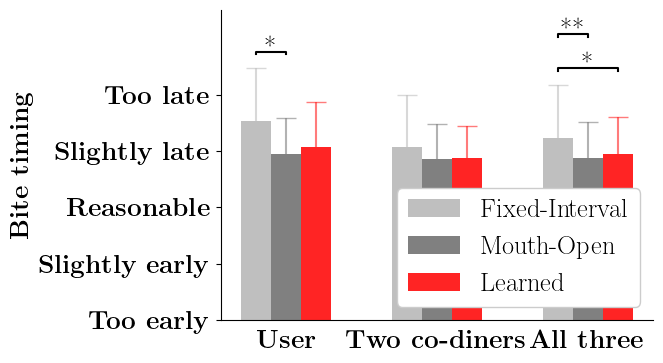

In [109]:
prompt_key = '1'
print(prompts[prompt_key])

bitetiming_ratings = ['Too early', 'Slightly early', 'Reasonable', 'Slightly late', 'Too late']
bitetiming_ratings = [ boldit(rating) for rating in bitetiming_ratings ]
    
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(7, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)

barplot_annotate_brackets(2, 8, p05, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(2, 5, p005, all_x, all_y, dh=.17, barh=0.01)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 5.5)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("Bite timing"))
plt.yticks(np.arange(5), bitetiming_ratings)
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_bitetiming.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.2.2 Distraction by the robot

I felt distracted by the robot


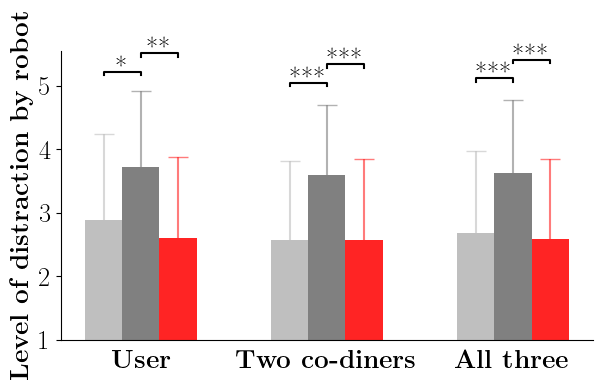

In [75]:
prompt_key = '2_1'
print(prompts[prompt_key])
    
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(3, 6, p005, all_x, all_y, dh=.1, barh=0.01)

barplot_annotate_brackets(1, 4, p0005, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(4, 7, p0005, all_x, all_y, dh=.1, barh=0.01)

barplot_annotate_brackets(2, 5, p0005, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(5, 8, p0005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 5.55)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("Level of distraction by robot"))
# Legend not needed if this figure is next to another one
# plt.legend(loc='lower right', framealpha=1)
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_distraction.pdf", format="pdf", bbox_inches="tight")
plt.show()

#### 2.2.2.3 Ability to have natural conversation with the group

I was able to have a natural conversation with the group


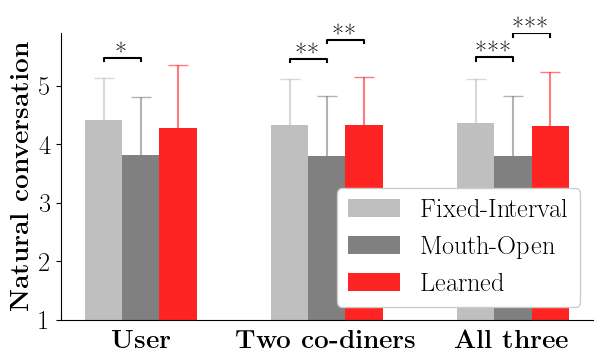

In [97]:
prompt_key = '2_2'
print(prompts[prompt_key])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)

barplot_annotate_brackets(1, 4, p005, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(4, 7, p005, all_x, all_y, dh=.1, barh=0.01)

barplot_annotate_brackets(2, 5, p0005, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(5, 8, p0005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 5.9)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("Natural conversation"))
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_natural_conversation.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.2.4 Ability to feel comfortable around the robot

I felt comfortable around the robot


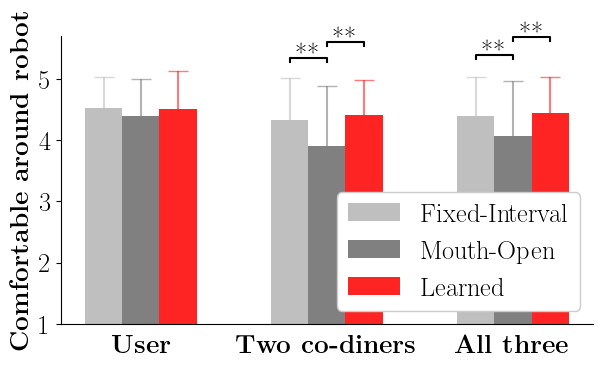

In [100]:
prompt_key = '2_3'
print(prompts[prompt_key])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks

barplot_annotate_brackets(1, 4, p005, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(4, 7, p005, all_x, all_y, dh=.1, barh=0.01)

barplot_annotate_brackets(2, 5, p005, all_x, all_y, dh=.05, barh=0.01)
barplot_annotate_brackets(5, 8, p005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 5.7)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("Comfortable around robot"))
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_comfortable.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.2.5 System reliability

The system is reliable


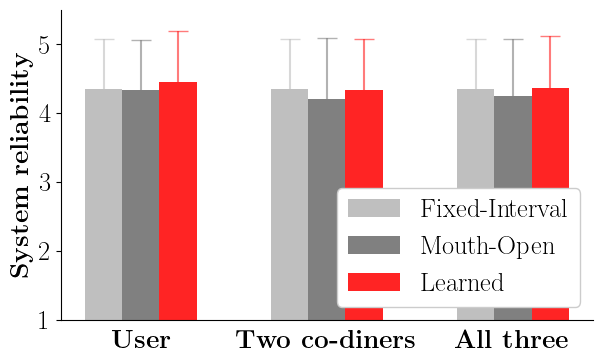

In [102]:
prompt_key = '2_4'
print(prompts[prompt_key])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
# barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(3, 6, p005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(1, 4, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(4, 7, p0005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(2, 5, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(5, 8, p0005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 5.5)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("System reliability"))
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_reliable.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.2.6 Ability to trust the system

I can trust the system


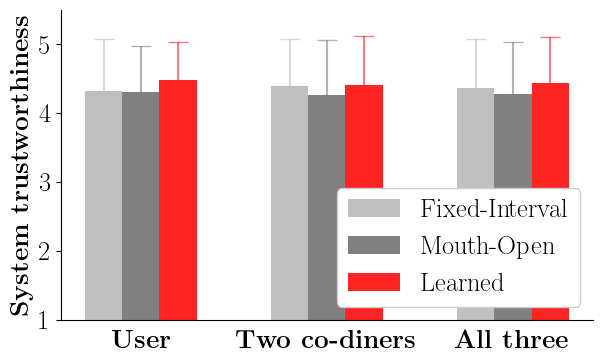

In [80]:
prompt_key = '2_5'
print(prompts[prompt_key])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
# barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(3, 6, p005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(1, 4, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(4, 7, p0005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(2, 5, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(5, 8, p0005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 5.5)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("System trustworthiness"))
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_trustworthy.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.2.7 Overall experience of the meal

My overall experience of the meal was great


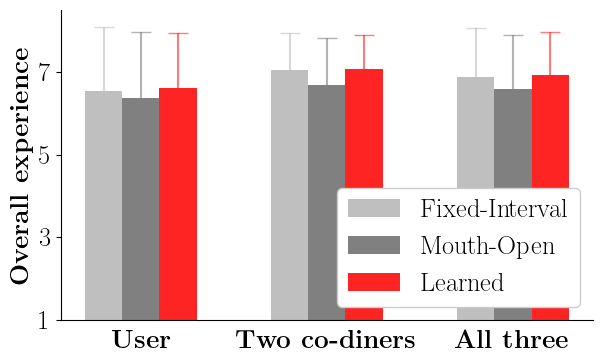

In [81]:
prompt_key = '3_1'
print(prompts[prompt_key])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
# barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(3, 6, p005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(1, 4, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(4, 7, p0005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(2, 5, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(5, 8, p0005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 7.5)
plt.yticks(np.arange(0, 7, step=2), np.arange(0, 7, step=2) + 1)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("Overall experience"))
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_overall_experience.pdf", format="pdf", bbox_inches="tight")
plt.show()


#### 2.2.2.8 Social interactions with the other participants

I liked the social interactions with the other participants very much


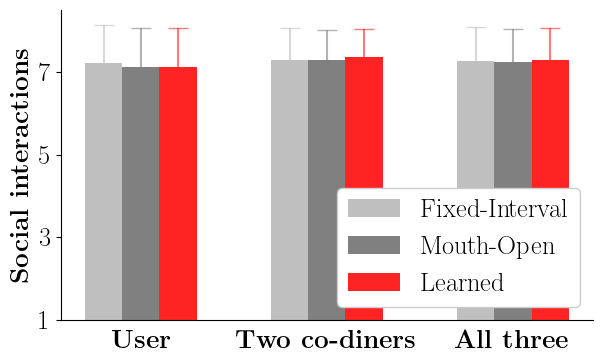

In [82]:
prompt_key = '3_2'
print(prompts[prompt_key])

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.size': 19, 
                     'font.family': 'serif',
                     'font.serif': ['Computer Modern'],
                     'text.usetex': True
                    })
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

remove_all_diners = False
err_kw = dict(alpha=alpha, capsize=7, capthick=None)
bin_width = 0.2
ys_means = []
ys_stds = []
x_pos = []
for i, (rater_label, ratings_data) in enumerate(zip(['By target users', 'By co-diners', 'By all'], [target_ratings[prompt_key], codiner_ratings[prompt_key], overall_ratings[prompt_key]])): 
    ys_means.extend( [np.mean(ratings_data[condition]) for condition in condition_labels.keys()] )
    ys_stds.extend( [np.std(ratings_data[condition]) for condition in condition_labels.keys()] )
    x_pos.extend( [x + (i - 1.5)*bin_width for x in range(3) ] )
    
colors = [(0.75, 0.75, 0.75), (0.5, 0.5, 0.5), (1.0,0.141,0.141) ] #  (1.0,0.9,0.9)
xlabels = ['User', 'Two co-diners', 'All three']
if remove_all_diners:
    xlabels = xlabels[:2]
alphas = np.array([
    [0.3, 0.3, 0.3], # condition a: 1, 2, 3 participants
    [0.3, 0.3, 0.3], # condition b: 1, 2, 3 participants
    [0.9, 0.9, 0.9]  # condition c: 1, 2, 3 participants
])

plt.figure(figsize=(6.4, 4))
all_x = []
all_y = []
for i, condition in enumerate(condition_labels.values()):
    for j, (x, y_mean, y_std) in enumerate(zip(x_pos[3*i:3*i+3], ys_means[i::3], ys_stds[i::3])):
        if remove_all_diners and j == 2: break
        err_kw.update(ecolor=colors[i])
        plt.bar(x, y_mean, yerr=y_std, error_kw=err_kw, width=bin_width, align='edge', label=condition if j == 0 else None, color=colors[i])
        all_x.append(x + bin_width/2)
        all_y.append(y_mean + y_std)

###############################################################
# User   |  Co-diners  | All three
# A,B,C  |  A,B,C      | A,B,C
# 0,3,6, |  1,4,7      | 2,5,8

p05 = .049
p005 = .0049
p0005 = .00049

# Statistical significance marks
# barplot_annotate_brackets(0, 3, p05, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(3, 6, p005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(1, 4, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(4, 7, p0005, all_x, all_y, dh=.1, barh=0.01)

# barplot_annotate_brackets(2, 5, p0005, all_x, all_y, dh=.05, barh=0.01)
# barplot_annotate_brackets(5, 8, p0005, all_x, all_y, dh=.1, barh=0.01)#, fs=15)
###############################################################

plt.xticks(np.arange(len(xlabels)), [boldit(l) for l in xlabels])
plt.ylim(1, 7.5)
plt.yticks(np.arange(0, 7, step=2), np.arange(0, 7, step=2) + 1)
# plt.xlabel('Bite timing strategy')
plt.ylabel(boldit("Social interactions"))
# Legend not needed if this figure is next to another one
plt.legend(loc='lower right', framealpha=1)
# plt.legend()
plt.tick_params(bottom=False)
plt.tight_layout()
plt.savefig("results_social_interactions.pdf", format="pdf", bbox_inches="tight")
plt.show()


## 2.3 Open-ended questions

In [112]:
# The questions Q2, Q3, Q4 were also asked during the dataset collection
open_questions = {
    'Q1': 'Did you feel safe around the robot? Please elaborate',
    'Q2': "Please list a few things that you liked about the meal experience you just had",
    'Q3': "Please list a few things that you didn't like about the meal experience you just had",
    'Q4': "When do you think it is appropriate to take a bite of food when you are eating with others? Please share your thoughts below."
}

# -R highlights the robot user participant
for question_key, question in open_questions.items():
    print('=' * 150)
    print(question)
    print('=' * 150)
    responses_sorted = sorted([ (f'{session_id}_{participant_position[0]}', response) if len(participant_position) == 1 else (f'{session_id}_{participant_position[0]}-R', response) for session_id, participant_position, response in zip(exp_df['I1'], exp_df['I2'], exp_df[question_key]) ])
    for participant_id, response in responses_sorted:
        print(f'{participant_id}\t| {response}')


Did you feel safe around the robot? Please elaborate
01_1-R	| Sort of. My primary concern was the robot’s resting state. When the neutral position has the fork poised at eye level it is very concerning. Simply aiming the fork down and away from the table would make a huge difference. 
01_2	| I was little uneasy at first but then I quickly forgot about it and was comfortable 
01_3	| Yes. It seemed to be under control nicely.
02_1-R	| Yes, I felt safe. The fork does come a bit close to my face when moving to pick up good though. 
02_2	| Yes: it helped that the robot moved pretty slowly and along familiar "tracks" through the air. The e-stop was nice to have too!
02_3	| The metal fork was slightly offputting (some sort of hard plastic may have been more comfortable). The visual design is also very clinical and slightly unnerving.
03_1-R	| Yes, it moves in a consistent manner, far from my body
03_2	| Yes
03_3	| Yes
04_1-R	| yes I did, It never tried to harm me or attack me in any way.
04_2

# 3 Correlations

## 3.1 Hunger level and absolute ratings

In [ ]:
For each factor evaluate correlation between ratings and the hunger level
=> e.g. hungry people find the robot to feed too late

